In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(1, '/home/janssens/scripts/pp3d/')
from functions import lowPass, mean_mask, getRad
from thermofunctions import *

In [95]:
# Inputs
it = 90
izmin = 0
izmax = 80
klp = 4
qlmin = 1e-10
lp = '/scratch-shared/janssens/eurec4a_mean_200km'

ds = nc.Dataset(lp+'/fielddump.001.nc')
ds2 = nc.Dataset(lp+'/cape2d.001.nc')
ds1= nc.Dataset(lp+'/profiles.001.nc')
ds0= nc.Dataset(lp+'/tmser.001.nc')

time  = np.ma.getdata(ds.variables['time'][:]) / 3600
zf    = np.ma.getdata(ds.variables['zt'][:]) # Cell centres (f in mhh)
zh    = np.ma.getdata(ds.variables['zm'][:]) # Cell edges (h in mhh)
xf    = np.ma.getdata(ds.variables['xt'][:]) # Cell centres (f in mhh)
yf    = np.ma.getdata(ds.variables['yt'][:]) # Cell centres (f in mhh)


time1d = np.ma.getdata(ds1.variables['time'][:])
rhobf = np.ma.getdata(ds1.variables['rhobf'][:])
rhobh = np.ma.getdata(ds1.variables['rhobh'][:])

zflim = zf[izmin:izmax]

# Vertical differences
dzf = np.zeros(zh.shape)
dzf[:-1] = zh[1:] - zh[:-1] # First value is difference top 1st cell and surface
dzf[-1] = dzf[-2]

dzh = np.zeros(zf.shape)
dzh[1:] = zf[1:] - zf[:-1] # First value is difference mid 1st cell and mid 1st cell below ground
dzh[0] = 2*zf[1]

dzflim = dzf[izmin:izmax]
dzhlim = dzh[izmin:izmax]

# Mask for low-pass filtering
circ_mask = np.zeros((xf.size,xf.size))
rad = getRad(circ_mask)
circ_mask[rad<=klp] = 1

print('time: ', time[it])

time:  22.75


/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app
/home/janssens/.conda/envs/ppaggenv/li

In [96]:
it1d = np.argmin(np.abs(time1d/3600 - time[it]))

# 1D fields
rhobfi = rhobf[it1d,izmin:izmax]
rhobhi = rhobh[it1d,izmin:izmax]

# 3D fields
qt  = np.ma.getdata(ds.variables['qt'][it,izmin:izmax,:,:])
# qr  = np.ma.getdata(ds.variables['sv002'][it,izmin:izmax,:,:])
wh = np.ma.getdata(ds.variables['w'][it,izmin:izmax+1,:,:])
thl =  np.ma.getdata(ds.variables['thl'][it,izmin:izmax,:,:])
ql = np.ma.getdata(ds.variables['ql'][it,izmin:izmax,:,:])
# buoy =  np.ma.getdata(ds.variables['buoy'][i,izmin:izmax,:,:])
# u = np.ma.getdata(ds.variables['u'][plttime[i],izmin:izmax,:,:])
# v = np.ma.getdata(ds.variables['v'][plttime[i],izmin:izmax,:,:])

# thlv
thlv = thl + (rv/rd-1)*qt

wf = (wh[1:,:,:] + wh[:-1,:,:])*0.5
wh = wh[:-1,:,:]

wff = lowPass(wf, circ_mask)

/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/home/janssens/.conda/envs/ppaggenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
/home/janssens/.conda/envs

In [97]:
# Moist/dry definition
twp = np.trapz(rhobfi[:,np.newaxis,np.newaxis]*qt[:,:,:],zflim,axis=0)
twpf = lowPass(twp, circ_mask)
twppf = twpf - np.mean(twp)
mask_moist = np.zeros(twp.shape)
mask_moist[twpf - np.median(twp) > 0] = 1
mask_dry = 1 - mask_moist

In [98]:
# Try to make Geet's circulation diagnostic
div_w = -(wff[1:,:,:] - wff[:-1,:,:])/dzhlim[1:,np.newaxis,np.newaxis]
div_w = (div_w[1:,:,:] + div_w[:-1,:,:])*0.5

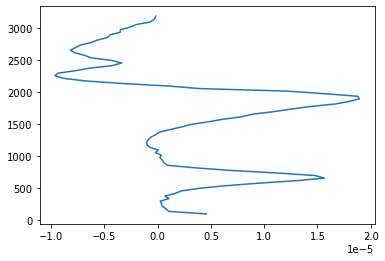

In [107]:
ql_av = np.mean(ql,axis=(1,2))
zcb = zflim[ql_av>1e-8][0]

thlv_av = np.mean(thlv,axis=(1,2))
thlv_av_grad = (thlv_av[1:] - thlv_av[:-1])/dzhlim[1:]
thlv_av_gg = (thlv_av_grad[1:] - thlv_av_grad[:-1])/dzhlim[2:]
izinv = np.argmax(thlv_av_grad)

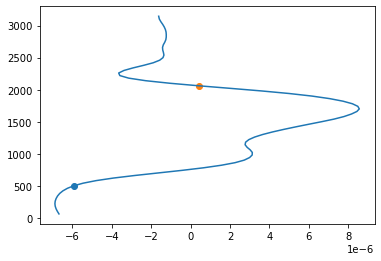

In [100]:
div_w_moist = mean_mask(div_w,mask_moist)
wff_moist = mean_mask(wff,mask_moist)

plt.plot(div_w_moist,zflim[1:-1])
plt.scatter(div_w_moist[izcb-1], zflim[izcb])
plt.scatter(div_w_moist[izinv-1], zflim[izinv])

Text(0, 0.5, '$\\mathcal{D}$ s$^{-1}$')

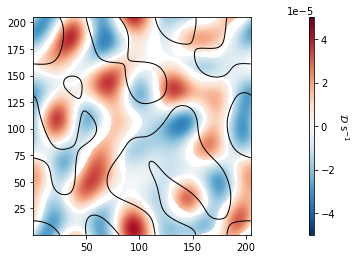

In [101]:
izcb = np.argmin(np.abs(zcb - zflim[1:-1]))
div_sc = np.mean(div_w[:izcb,:,:],axis=0)
div_cl = np.mean(div_w[izcb:izinv,:,:],axis=0)
div_cl_sc = div_sc/div_cl

div_sc_ci = div_sc
div_sc_ci[div_cl_sc > 0] = np.nan

extent = np.array([xf.min(),xf.max(),yf.min(),yf.max()])/1000

fig=plt.figure(); ax = plt.gca()

sc3 = ax.imshow(div_sc_ci,cmap='RdBu_r',vmin=-5e-5,vmax=5e-5,extent=extent)

ax.contour(twppf,levels=[0],extent=extent,origin='upper',
                 linewidths=1,colors='black')

pos3 = ax.get_position()
cbax3 = fig.add_axes([.9, pos3.ymin, 0.01, pos3.height])
cb1 = fig.colorbar(sc3, cax=cbax3)
cb1.ax.set_ylabel(r"$\mathcal{D}$ s$^{-1}$", rotation=270, labelpad=15)


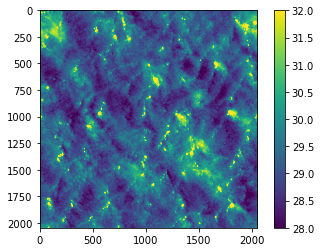

In [102]:
plt.imshow(twp,vmin=28,vmax=32)
plt.colorbar()